![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest parameter optimization
</b>
</span>

---
**Notebook version**: `1` (25 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch) 

</br>

# **Background**

- Finding optimal model parameters

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [1]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [2]:
import importlib.metadata
import warnings
from datetime import datetime

from diive.configs.exampledata import load_exampledata_parquet
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.pkgs.gapfilling.randomforest_ts import OptimizeParamsRFTS

warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.82.1


</br>

# **Docstring** for `RandomForestTS`

In [3]:
help(OptimizeParamsRFTS)

Help on class OptimizeParamsRFTS in module diive.pkgs.gapfilling.randomforest_ts:

class OptimizeParamsRFTS(builtins.object)
 |  OptimizeParamsRFTS(df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |  
 |  Optimize parameters for random forest model
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: pandas.core.frame.DataFrame, target_col: str, **rf_params: dict)
 |      Args:
 |          df: dataframe of target and predictor time series
 |          target_col: name of target in *df*, all variables that are not *target* are
 |              used as predictors
 |          **rf_params: dict of parameters for random forest model, where parameter ranges are
 |              provided as lists, e.g.
 |                  rf_params = {
 |                      'n_estimators': list(range(2, 12, 2)),
 |                      'criterion': ['root_mean_squared_error'],
 |                      'max_depth': [None],
 |                      'min_samples_split': list(range(2, 12, 

</br>

# **Load data**

## Load example data from parquet file

In [4]:
df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.040 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [5]:
subset = df[subsetcols].copy()
_subset = df.index.year >= 2020
subset = subset[_subset].copy()
subset

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
TIMESTAMP_MIDDLE,,,,
2020-01-01 00:15:00,NaN,-0.610,2.101,0.0
2020-01-01 00:45:00,NaN,-0.403,2.262,0.0
2020-01-01 01:15:00,NaN,-0.517,2.216,0.0
2020-01-01 01:45:00,0.009,-0.460,2.269,0.0
2020-01-01 02:15:00,NaN,-0.607,2.198,0.0
...,...,...,...,...
2022-12-31 21:45:00,NaN,3.463,2.210,0.0
2022-12-31 22:15:00,3.518,5.283,3.327,0.0
2022-12-31 22:45:00,NaN,5.537,3.467,0.0


In [6]:
subset.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,17854.000000,52608.000000,52608.000000,52608.000000
mean,-3.168904,4.906338,3.180231,158.514053
std,5.642207,7.462950,3.722807,255.365855
min,-27.522000,-15.897000,0.000000,0.000000
25%,-6.869750,-0.623000,0.517000,0.000000
50%,-2.700000,4.730000,1.981000,4.078500
75%,0.785750,10.277000,4.357000,234.918000
max,20.974000,26.587000,27.903000,1197.800000


In [7]:
sstats(subset[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2020-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,1095 days 23:30:00
NOV,17854
MISSING,34754
MISSING_PERC,66.062196
MEAN,-3.168904
MEDIAN,-2.7
SD,5.642207
VAR,31.834502


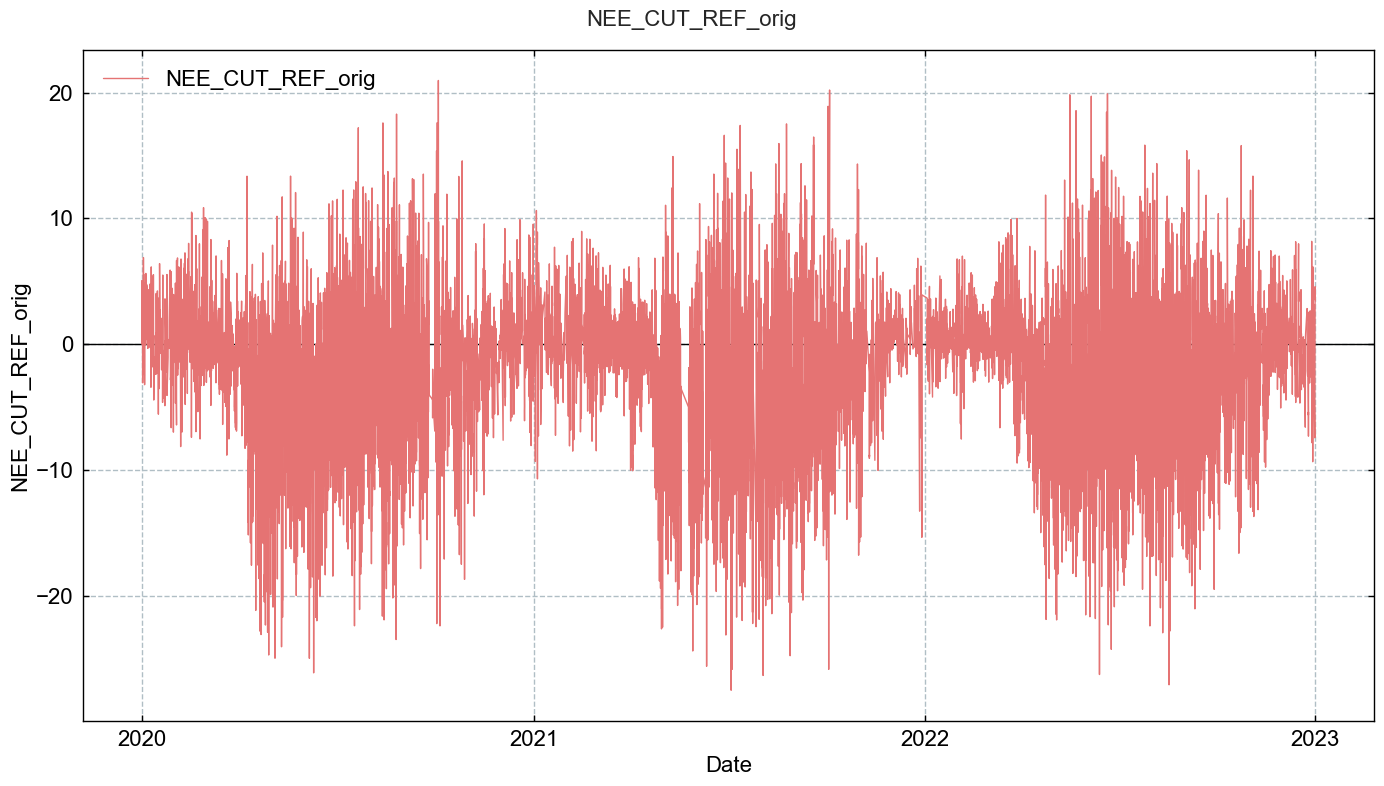

In [8]:
# TimeSeries(series=subset[TARGET_COL]).plot_interactive()
TimeSeries(series=subset[TARGET_COL]).plot()

</br>

</br>

# **Parameter optimization**

## Initialize

In [9]:
# Random forest parameters
rf_params = {
    'n_estimators': [10, 20],
    # 'n_estimators': list(range(3, 33, 3)),
    'criterion': ['squared_error'],
    # 'max_depth': list(range(1, 35, 1)),
    'max_depth': [6, 12],  # Can also be None
    'min_samples_split': [10, 40],
    # 'min_samples_split': list(range(2, 12, 2)),
    'min_samples_leaf': [5, 20],
    # 'min_samples_leaf': list(range(2, 12, 2))
}

# Optimization
opt = OptimizeParamsRFTS(
    df=subset,
    target_col=TARGET_COL,
    **rf_params
)

</br>

## Optimize parameters

In [10]:
%%time
opt.optimize()

CPU times: total: 656 ms
Wall time: 3.61 s


</br>

## Result

In [11]:
print("Estimator which gave highest score (or smallest loss if specified) on the left out data:")
display(opt.best_params)
print("\nModel scores for best model:")
display(opt.scores)
print(f"\nMean cross-validated score of the best_estimator: {opt.best_score}")
print(f"\nThe number of cross-validation splits (folds/iterations): {opt.cv_n_splits}")

Estimator which gave highest score (or smallest loss if specified) on the left out data:


{'criterion': 'squared_error',
 'max_depth': 12,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 20}


Model scores for best model:


{'mae': np.float64(2.5677662013178435),
 'medae': np.float64(1.810421824268568),
 'mse': np.float64(13.112836010650257),
 'rmse': np.float64(3.6211650073768054),
 'mape': np.float64(1.7195831450463424),
 'maxe': np.float64(24.112641797163135),
 'r2': 0.6039088930887981}


Mean cross-validated score of the best_estimator: -12.444533691647242

The number of cross-validation splits (folds/iterations): 10


In [12]:
# Cross-validation results
opt.cv_results.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
13,0.217974,0.114719,0.002500,0.000500,squared_error,12,20,10,20,"{'criterion': 'squared_error', 'max_depth': 12...",-13.541101,-12.336043,-11.396652,-11.671356,-11.729071,-12.798584,-13.555599,-11.100431,-11.999073,-14.317427,-12.444534,1.014621,1
11,0.251678,0.135819,0.003401,0.001357,squared_error,12,5,40,20,"{'criterion': 'squared_error', 'max_depth': 12...",-13.513659,-12.598449,-11.463558,-11.549558,-11.744541,-12.717398,-13.695560,-11.018603,-11.862846,-14.511314,-12.467549,1.081547,2
15,0.192272,0.095790,0.002300,0.000458,squared_error,12,20,40,20,"{'criterion': 'squared_error', 'max_depth': 12...",-13.706369,-12.460728,-11.295500,-11.749442,-11.774928,-12.970842,-13.519825,-11.093118,-11.927870,-14.395315,-12.489394,1.056231,3
12,0.112608,0.063514,0.001500,0.000500,squared_error,12,20,10,10,"{'criterion': 'squared_error', 'max_depth': 12...",-13.688970,-12.348515,-11.351432,-11.868646,-11.901936,-13.026612,-13.764329,-11.123542,-12.006423,-14.361583,-12.544199,1.047480,4
10,0.126113,0.072128,0.001900,0.000943,squared_error,12,5,40,10,"{'criterion': 'squared_error', 'max_depth': 12...",-13.734738,-12.461159,-11.564596,-11.821229,-11.800316,-12.846818,-13.709344,-11.294704,-12.091052,-14.540642,-12.586460,1.031678,5
14,0.110261,0.060480,0.001401,0.000663,squared_error,12,20,40,10,"{'criterion': 'squared_error', 'max_depth': 12...",-13.431629,-12.645085,-11.557266,-11.871930,-12.135152,-13.088265,-13.531704,-11.254115,-12.297157,-14.359795,-12.617210,0.929011,6
9,0.283478,0.153455,0.003300,0.000781,squared_error,12,5,10,20,"{'criterion': 'squared_error', 'max_depth': 12...",-13.484740,-12.921061,-11.616433,-11.853412,-11.836274,-12.929145,-13.814136,-11.215172,-12.064483,-14.588541,-12.632340,1.035604,7
8,0.144165,0.082351,0.002001,0.000447,squared_error,12,5,10,10,"{'criterion': 'squared_error', 'max_depth': 12...",-13.819000,-12.979821,-11.819735,-12.061929,-11.957530,-13.331832,-13.879950,-11.072836,-12.249165,-14.865376,-12.803718,1.108486,8
3,0.173221,0.083887,0.002551,0.000473,squared_error,6,5,40,20,"{'criterion': 'squared_error', 'max_depth': 6,...",-13.622724,-12.464060,-11.748171,-12.043317,-12.081940,-13.377058,-13.899675,-11.578857,-12.665014,-14.957627,-12.843844,1.033058,9
1,0.184670,0.093960,0.002451,0.000472,squared_error,6,5,10,20,"{'criterion': 'squared_error', 'max_depth': 6,...",-13.329793,-12.434644,-11.803718,-12.111184,-12.238408,-13.411362,-13.879045,-11.515321,-12.773022,-15.046885,-12.854338,1.020039,10


In [13]:
r = opt.cv_results.sort_values(by="rank_test_score").loc[:, "params"]
# [print(rr) for rr in r]
print(*[i for i in r], sep="\n")

{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
{'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 10}
{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 5

</br>

## Plot

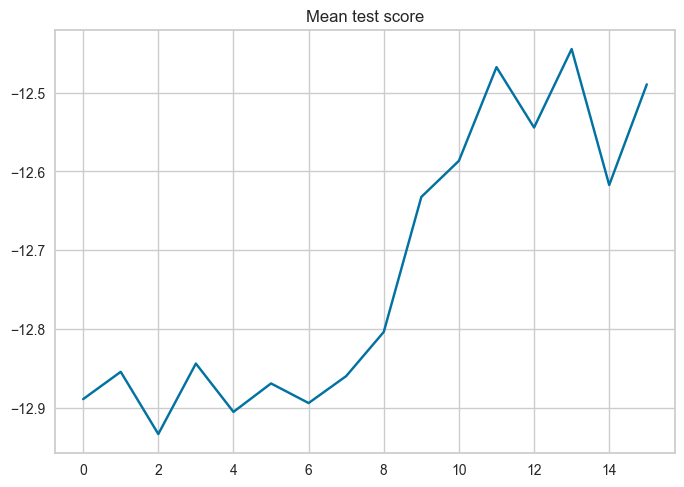

In [14]:
opt.cv_results['mean_test_score'].plot(title="Mean test score");

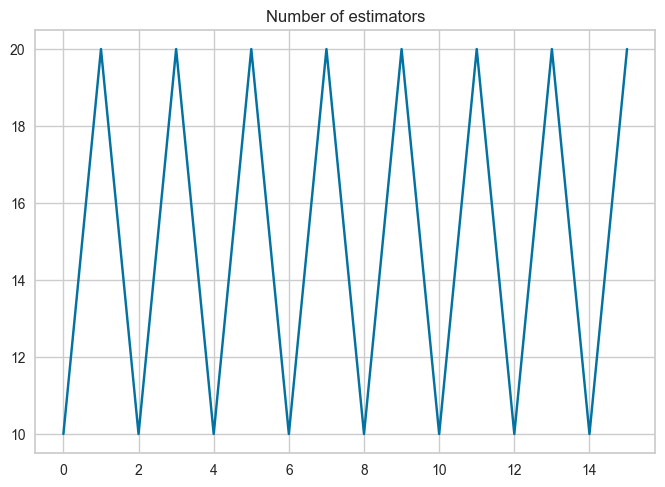

In [15]:
opt.cv_results['param_n_estimators'].plot(title="Number of estimators");

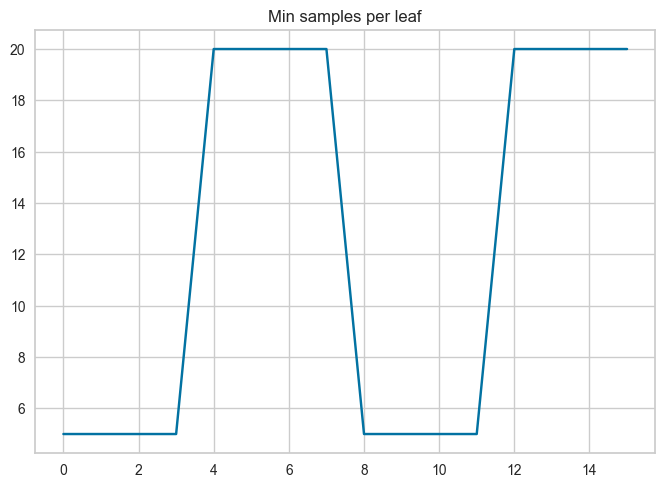

In [16]:
opt.cv_results['param_min_samples_leaf'].plot(title="Min samples per leaf");

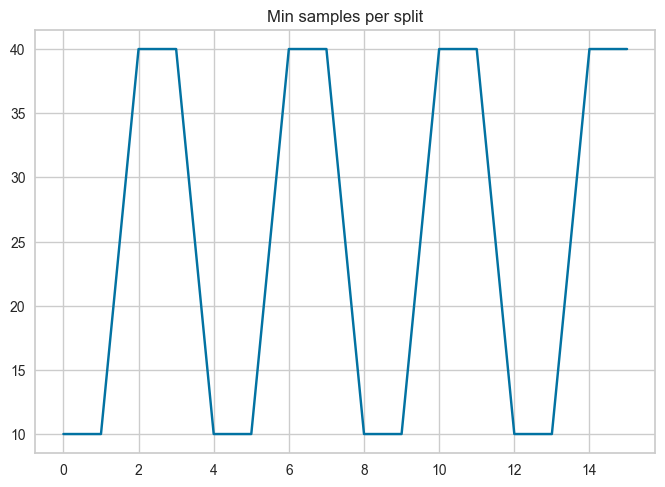

In [17]:
opt.cv_results['param_min_samples_split'].plot(title="Min samples per split");

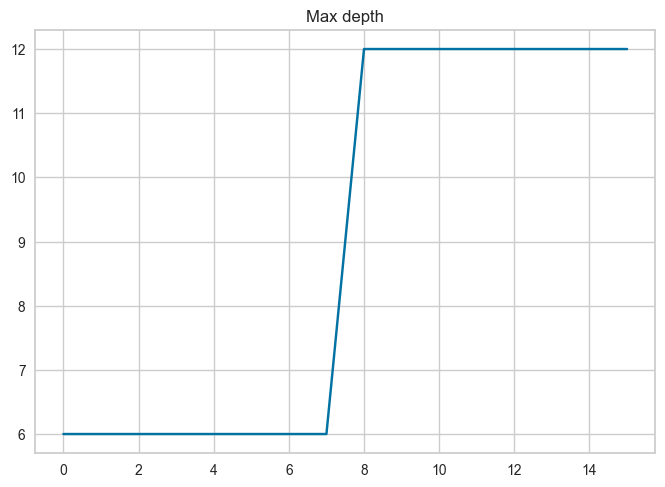

In [18]:
opt.cv_results['param_max_depth'].plot(title="Max depth");

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [19]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-09-20 00:16:20
